In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras

from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras.layers.advanced_activations import ELU
from keras import regularizers
from keras.models import load_model
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path



Using TensorFlow backend.


## Load data and Preprocessing

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# Load data and exclude nan value
data = np.genfromtxt('IRISwest.txt')

In [3]:
#####maybe if we cut out the IRIS P waves we can get better results## 
#going to chooose 6000 

eqgpstime = data[:,1]
peakgpstime = data[:,17]
arrivaltime = np.subtract(peakgpstime,eqgpstime)
distance = data[:,13]
Velocity = np.divide(distance, arrivaltime)
pwaveomit = 6000
Velocity1 = Velocity[Velocity<6000]
data = data[Velocity<6000]
print (len(data))

169232


In [4]:


########cutting to only use western hemi data, not needed for IRISwest.txt##########
######side note for sky, refernces w/ [:,] instead of np.array
#print(len(data1))
#eq_lon1 =data1[:,11]
#print(eq_lon1)
#data = data1[(eq_lon1>=-180) & (eq_lon1<=-30)]
#print(len(data))
#########cutting out ocean points ############

eq_lat2 = data[:,11]
eq_lon2 = data[:,12]
map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
lats = eq_lat2  #[:100]                                                                                                        \
                                                                                                                                
lons = eq_lon2
x, y = map1(lons, lats)
locations = np.c_[x, y]
polygons = [Path(p.boundary) for p in map1.landpolygons]
result = np.zeros(len(locations), dtype=bool)
for polygon in polygons:
    result += np.array(polygon.contains_points(locations))

eq_lat1=lats[result]
eq_lon1=lons[result]
print (len(data))
print (result)
data =data[result]
print (len(data))




169232
[False False  True ...  True  True False]
29635


In [5]:
# Extract X and y and divide into train, val, and test set
X = data[:, [2, 11, 12, 13, 14, 15]]   #side note nikils has log10distnace maybe we should try that
 # y = (data[:, 24] - data[:, 0])
y = np.log10(data[:, 18]) #(tri's org)
#y = data[:,25]


# Data preprocessing
# Exclude bad data
#z = np.log10(1e-6)
mask = y > -6.0 #-6.5 #(tri's orig)
#mask = y > 1e-6
y = y[mask]
X = X[mask]

###if i were to try and test on all data (good or bad idea?)

print(y.shape)

# Normalizing
X -= np.mean(X, axis=0) #these standard deviations need to be changed if im not doing log?
X /= np.std(X, axis=0)

mean_y = np.mean(y, axis=0)
stdv_y = np.std(y, axis=0)
y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) #(does this work with seed)
X = X[mask]
y = y[mask]

tfrac = int(0.8*y.size) 
X_train = X[:tfrac]
y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]

#trying to test against all of itself
#tfrac = int(1*y.size) 
#X_train = X[:tfrac]
#y_train = y[:tfrac]
#X_val = X[:tfrac]
#y_val = y[:tfrac]



print('')
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

(28870,)

X_train shape: (23096, 6)
y_train shape: (23096,)
X_val shape: (5774, 6)
y_val shape: (5774,)


## Create a DENSE network

In [6]:
def QuakeNet(input_shape, lr=1e-3, reg=0.00, dropout=0.2):
      #orig (input_shape, lr=1e-3, reg=0.00, dropout=0.0)
    X_input = Input(input_shape)
    
    X = Dense(512, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X_input) 
    
    X = Dense(256, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X) 
    X = Dense(128, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    ####X = Dense(16, kernel_regularizer=regularizers.l2(reg),
       ###    #   activation='sigmoid')(X)
    X = Dense(64, kernel_regularizer=regularizers.l2(reg),
             activation='relu')(X)       
    
    X = Dense(32, kernel_regularizer=regularizers.l2(reg),
             activation='relu')(X)
    X = Dense(16, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
   # X = Dense(64, kernel_regularizer=regularizers.l2(reg),
       #       activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(1, kernel_regularizer=regularizers.l2(reg))(X)

    model = Model(inputs=X_input, outputs=X, name='QuakeNet')
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    
    return model

In [7]:
input_shape = (X_train.shape[1], )
model = QuakeNet(input_shape=input_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3584      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
__________

## Train

In [8]:
stats = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

Train on 23096 samples, validate on 5774 samples
Epoch 1/200
23096/23096 [==============================] - 2s 105us/step - loss: 0.3768 - val_loss: 0.2735
Epoch 2/200
23096/23096 [==============================] - 2s 84us/step - loss: 0.3048 - val_loss: 0.2640
Epoch 3/200
23096/23096 [==============================] - 2s 84us/step - loss: 0.2887 - val_loss: 0.2442
Epoch 4/200
23096/23096 [==============================] - 2s 85us/step - loss: 0.2632 - val_loss: 0.2098
Epoch 5/200
23096/23096 [==============================] - 2s 86us/step - loss: 0.2623 - val_loss: 0.2042
Epoch 6/200
23096/23096 [==============================] - 2s 87us/step - loss: 0.2585 - val_loss: 0.2452
Epoch 7/200
23096/23096 [==============================] - 2s 86us/step - loss: 0.2520 - val_loss: 0.2250
Epoch 8/200
23096/23096 [==============================] - 2s 86us/step - loss: 0.2379 - val_loss: 0.1963
Epoch 9/200
23096/23096 [==============================] - 2s 86us/step - loss: 0.2341 - val_loss: 0.2

23096/23096 [==============================] - 2s 88us/step - loss: 0.1464 - val_loss: 0.1114
Epoch 78/200
23096/23096 [==============================] - 2s 97us/step - loss: 0.1432 - val_loss: 0.1192
Epoch 79/200
23096/23096 [==============================] - 3s 133us/step - loss: 0.1429 - val_loss: 0.1173
Epoch 80/200
23096/23096 [==============================] - 4s 166us/step - loss: 0.1420 - val_loss: 0.1116
Epoch 81/200
23096/23096 [==============================] - 4s 161us/step - loss: 0.1431 - val_loss: 0.1097
Epoch 82/200
23096/23096 [==============================] - 3s 143us/step - loss: 0.1447 - val_loss: 0.1198
Epoch 83/200
23096/23096 [==============================] - 3s 111us/step - loss: 0.1515 - val_loss: 0.1161
Epoch 84/200
23096/23096 [==============================] - 2s 87us/step - loss: 0.1435 - val_loss: 0.1165
Epoch 85/200
23096/23096 [==============================] - 2s 84us/step - loss: 0.1449 - val_loss: 0.1153
Epoch 86/200
23096/23096 [===================

23096/23096 [==============================] - 2s 83us/step - loss: 0.1316 - val_loss: 0.1030
Epoch 154/200
23096/23096 [==============================] - 2s 83us/step - loss: 0.1259 - val_loss: 0.1074
Epoch 155/200
23096/23096 [==============================] - 2s 83us/step - loss: 0.1277 - val_loss: 0.1049
Epoch 156/200
23096/23096 [==============================] - 2s 84us/step - loss: 0.1315 - val_loss: 0.1014
Epoch 157/200
23096/23096 [==============================] - 2s 85us/step - loss: 0.1236 - val_loss: 0.1005
Epoch 158/200
23096/23096 [==============================] - 2s 87us/step - loss: 0.1271 - val_loss: 0.1056
Epoch 159/200
23096/23096 [==============================] - 2s 91us/step - loss: 0.1276 - val_loss: 0.1019
Epoch 160/200
23096/23096 [==============================] - 2s 104us/step - loss: 0.1296 - val_loss: 0.1076
Epoch 161/200
23096/23096 [==============================] - 2s 104us/step - loss: 0.1299 - val_loss: 0.1021
Epoch 162/200
23096/23096 [=============

## Predict

In [9]:
model.save('iwgv6.hdf5')
#from keras.model import load_model

model = load_model('iwgv6.hdf5')

In [10]:
y_pred = model.predict(X_val) # X_val could be new data too?
# Inverse-normalize
y_val = y_val*stdv_y + mean_y
y_pred = y_pred*stdv_y + mean_y

(5774,)
(5774,)


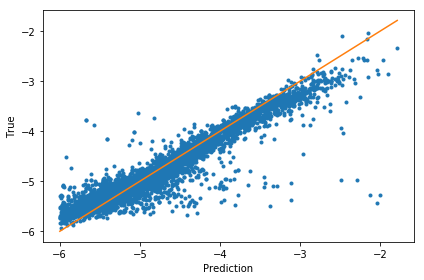

In [11]:
print(y_val.shape)
y_pred = y_pred.flatten()

#print(y_pred.shape)
#fig, ax = plt.subplots()

#v_min = min(np.min(y_val), np.min(y_pred))
#v_max = max(np.max(y_val), np.max(y_pred))
#x = np.linspace(v_min, v_max, 1000)

#ax.plot(y_val, y_pred, '.')
#ax.plot(x, x)
#ax.set(xlabel='Prediction', ylabel='True')

#fig.tight_layout()

/anaconda3/envs/ligo/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


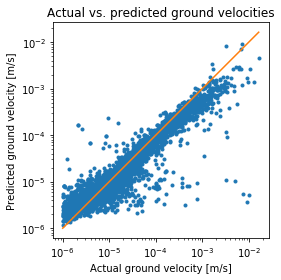

In [12]:
absy_val = abs(y_val)
absy_pred = abs(y_pred)

#taking antilog so we can see what we are used too 
antiy_val = 10**y_val
antiy_pred = 10**y_pred

v_min = min(np.min(antiy_val), np.min(antiy_pred))
v_max = max(np.max(antiy_val), np.max(antiy_pred))
x = np.linspace(v_min, v_max, 1000)

fig, ax = plt.subplots()

ax.loglog(antiy_val, antiy_pred, '.')
ax.plot(x, x)
ax.set(ylabel='Predicted ground velocity [m/s]', xlabel='Actual ground velocity [m/s]',title = 'Actual vs. predicted ground velocities' )
ax.set(adjustable='box-forced', aspect='equal')
#ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
fig.tight_layout()

plt.savefig('iriswestomit1.png', dpi =300,bbox_inches='tight')
#plt.show()



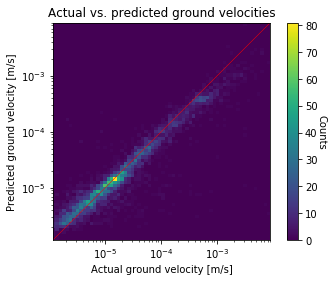

In [13]:
x = np.linspace(v_min, v_max, 1000)
fig2, ax, = plt.subplots()
x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(antiy_val.max()),np.sqrt(5000)) #12279
y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(antiy_pred.max()),np.sqrt(5000))
H, xedges, yedges = np.histogram2d(antiy_val, antiy_pred, bins=[x_bins,y_bins])
#ax2 = fig.add_subplot(212)
h = ax.pcolormesh(xedges, yedges, H.T)
#ax.set_aspect('equal')
#ax.set(adjustable='box-forced', aspect='equal')
#a2.imshow(img, origin='lower', extent=extent, aspect='auto')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
ax.set(ylabel='Predicted ground velocity [m/s]', xlabel='Actual ground velocity [m/s]',title = 'Actual vs. predicted ground velocities')




cbar = plt.colorbar(h, ax=ax)
ax.plot(x, x, c='r',linewidth=.5)
#ax.set_ylim([0, 10e-2])
#ax.set_xlim([0, 10e-2])
#ax.set_aspect('equal')
#cbar =plt.colorbar()
#cbar.ax.set_ylabel('Counts')
cbar.set_label('Counts', rotation=270,labelpad=9)

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('iriswestdensityomit1.png', dpi =300,bbox_inches='tight')

plt.show()

[1.19170004 0.13781537 0.17829287 ... 0.10130263 0.40487907 0.06406664]
(5774,)
5.4257824656896914e-05
76.16102123598841
0.4001718060438368


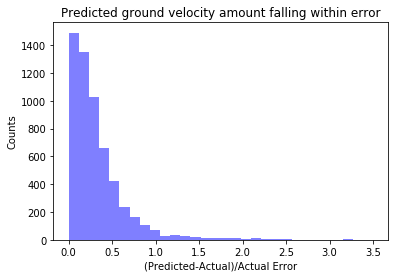

In [14]:
z = np.array(abs((antiy_val -antiy_pred)/antiy_val))

print(z)
print(z.shape)
print(np.min(z))
print(np.max(z))
print (np.average(z))
#x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(antiy_val.max()),np.sqrt(12279))
#y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(antiy_pred.max()),np.sqrt(12279))
plt.hist(z, bins=30,range =[0,3.5], facecolor='blue', alpha=0.5)
plt.xlabel('(Predicted-Actual)/Actual Error')
plt.ylabel('Counts')
plt.title('Predicted ground velocity amount falling within error')
plt.savefig('iriswesthistomit1.png', dpi =300,bbox_inches='tight')
plt.show()